<a href="https://colab.research.google.com/github/ahhyun-moon/6643-computer-vision/blob/main/%08CV3_Hough_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as p

In [ ]:
def hough_transform(img, delta_rho=1, delta_theta=1):
  # Set up accumulator array
  height, width = img.shape
  max_rho = int(np.ceil(np.sqrt(height**2 + width**2)))
  delta_theta_radian = delta_theta * np.pi/180
  num_thetas = int(np.pi / delta_theta_radian)
  unassigned_rho = 2 * max_rho
  accumulator = np.zeros((unassigned_rho, num_thetas), dtype=np.uint64)
  # Get thetas and rhos
  thetas = np.linspace(0, np.pi, num_thetas)
  rhos = np.arange(-max_rho, max_rho, delta_rho)
  # Calculate sin and cos values of thetas
  sin_thetas = np.sin(thetas)
  cos_thetas = np.cos(thetas)
  # Find non-zero pixel indices
  ys, xs = np.nonzero(img)
  # For each edge pixel
  for y, x in zip(ys, xs):
    # Iterate over each theta value and get rho value to update accumulator
    for i in range(num_thetas):
      rho = int(x * cos_thetas[i] + y * sin_thetas[i])
      pos_rho = rho + max_rho
      accumulator[pos_rho, i] += 1
  return accumulator, thetas, rhos

def detect_peaks(accumulator, N=10, radius=1):
    # Get the dimensions of the accumulator
    rows, cols = accumulator.shape
    peaks = []
    # Loop through each cell in the accumulator
    for r in range(rows):
        for c in range(cols):
            if accumulator[r, c] > 0:
              center = accumulator[r, c]
              # Extract a window of (2 * radius - 1) x (2 * radius - 1) around the current cell
              # 8 neighbors when radius = 1
              row_start = max(r - radius, 0)
              row_end = min(r + radius + 1, rows)
              col_start = max(c - radius, 0)
              col_end = min(c + radius + 1, cols)
              # Get the neighborhood within the radius
              neighborhood = accumulator[row_start:row_end, col_start:col_end]
              # Check if the current cell is the maximum in the neighborhood
              if np.max(neighborhood) == center:
                  peaks.append((r, c, center))
    # Sort the peaks by their accumulator values (optional)
    peaks = sorted(peaks, key=lambda x: x[2], reverse=True)

    # Return only the top N peaks
    return peaks[:N]

def normalize_2d(accumulator):
  # Adjust cell value to [0 - 255]
  accumulator = (accumulator - accumulator.min()) / \
                (accumulator.max() - accumulator.min()) * 255
  return accumulator.astype(np.uint8)

def draw_peaks(accumulator, peaks, thetas, rhos, ellipse_h=20):
  # Draw peaks circles on the accumulator array
  accumulator_with_marks = normalize_2d(np.log(accumulator + 1))
  aspect_ratio = accumulator_with_marks.shape[1]/accumulator_with_marks.shape[0]
  # plt.figure(figsize=[8,8])
  fig = plt.gcf()
  ax = fig.gca()
  ellipse_w = ellipse_h * np.pi/180 * aspect_ratio
  for rho, theta, _ in peaks:
    center_coordinates = (thetas[theta], rhos[rho])
    print(center_coordinates, _)
    ellipse = p.Ellipse(center_coordinates, ellipse_w, ellipse_h,
                        color='red', fill=False)
    ax.add_patch(ellipse)
  plt.title('Hough Space with '+ str(len(peaks)) +' Peaks')
  plt.xlabel('Theta (radians)')
  plt.ylabel('Rho')
  plt.imshow(accumulator_with_marks, cmap='gray', aspect='auto',
             extent=[thetas[0],thetas[-1],rhos[-1],rhos[0]])


import cv2 # For drawing lines

def draw_lines(image, peaks, rhos, thetas, isGreyscale=True):
  # Convert from grayscale to color for red lines
  if isGreyscale: image = gray_to_color(image)
  for rho, theta, _ in peaks:
    a = np.cos(thetas[theta])
    b = np.sin(thetas[theta])
    x0 = a * rhos[rho]
    y0 = b * rhos[rho]
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
  return image

def gray_to_color(gray_image):
  height, width = gray_image.shape
  color_image = np.zeros((height, width, 3), dtype=np.uint8)
  # Replicate the grayscale intensity values across all three color channels
  color_image[:, :, 0] = gray_image
  color_image[:, :, 1] = gray_image
  color_image[:, :, 2] = gray_image
  return color_image

In [ ]:
# Edge Detection from Project 2

def convolution(f, I):
  # Convert input images into float arrays
  filter = np.array(f, dtype=float)
  image = np.array(I, dtype=float)

  # Get dimensions of the image and kernel
  if len(filter.shape) == 1:
    f_height = 1
    f_width = len(filter)
  else:
    f_height, f_width = np.shape(filter)

  if len(image.shape) == 1:
    i_height = 1
    i_width = len(image)
  else:
    i_height, i_width = np.shape(image)

  pad_height = f_height // 2
  pad_width = f_width // 2
  if pad_height == 0: pad_height = 1
  if pad_width == 0: pad_width = 1

  padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')

  # Compute im_conv = f*I
  im_conv = np.zeros_like(image, dtype=float)

  # Perform convolution
  for i in range(i_height):
    for j in range(i_width):
      im_conv[i, j] = np.sum(padded_image[i:i+f_height, j:j+f_width] * f)

  return im_conv

def gradient_magnitude(dx, dy):
  return np.sqrt(np.square(dx) + np.square(dy))

def threshold_image(image, threshold):
  return (image > threshold) * 255

def imageAdjust(image):
  min_val = np.min(image)
  max_val = np.max(image)
  adjusted = ((image - min_val) / (max_val - min_val) * 255)
  return adjusted.astype(np.uint8)

def first_derivatives(image):
  dx_filter = np.array([[-1, 0, 1]])
  dy_filter = dx_filter.T
  dx = convolution(dx_filter, image)
  dy = convolution(dy_filter, image)
  return dx,dy

def gaussian_filter(sigma):
  size = int(6 * sigma + 1)
  if size % 2 == 0:
    size += 1
  center = size // 2
  kernel = np.zeros(size)
  for i in range(size):
    x = i - center
    kernel[i] = np.exp(-x**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
  kernel /= np.sum(kernel)
  return kernel

def denoise_image(image, sigma):
  # Create 1D Gaussian filters for horizontal and vertical directions
  Gx = gaussian_filter(sigma)
  Gy = np.vstack(Gx)
  intermediate_result = convolution(Gx, image)
  denoised_image = convolution(Gy,intermediate_result)
  return denoised_image

def median_filter(image, kernel_size):
  height, width = image.shape
  filtered_image = np.zeros_like(image)
  padding = kernel_size // 2

  for i in range(padding, height - padding):
    for j in range(padding, width - padding):
      window = image[i - padding:i + padding + 1, j - padding:j + padding + 1]
      filtered_image[i, j] = np.median(window)

  return filtered_image

In [ ]:
crosswalk_img = Image.open('/content/drive/MyDrive/ComputerVision_Project3/crosswalk.png')
crosswalk_img_arr = np.array(crosswalk_img.convert('L')).astype(float)

c_first_der_x,c_first_der_y = first_derivatives(crosswalk_img_arr)
c_first_der_gradient = gradient_magnitude(c_first_der_x, c_first_der_y)

# Adjust values for display
c_dx_adjusted = imageAdjust(c_first_der_x)
c_dy_adjusted = imageAdjust(c_first_der_y)
c_magnitude_adjusted = imageAdjust(c_first_der_gradient)


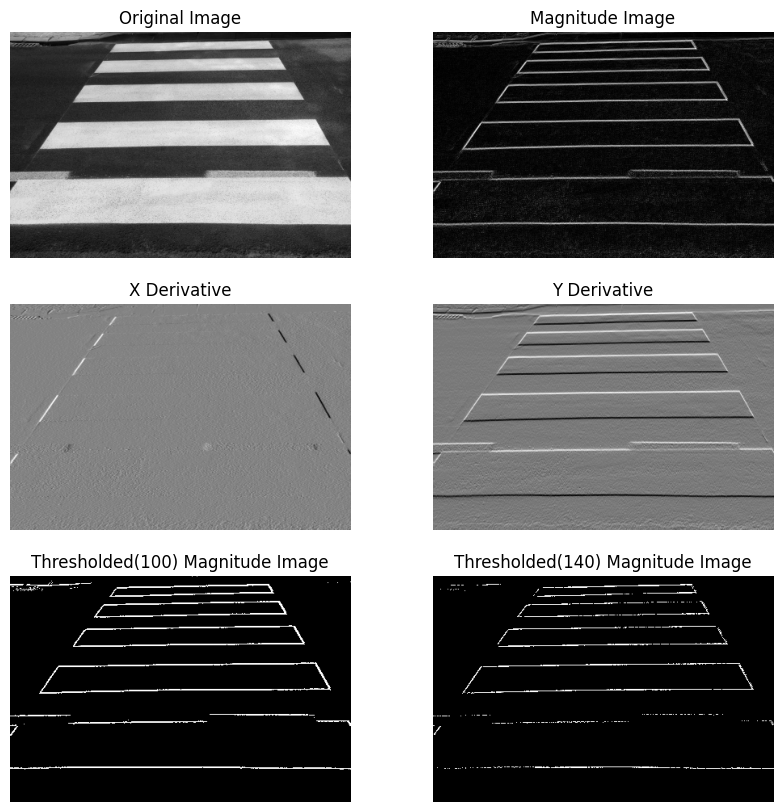

In [ ]:
# Threshold the magnitude image
c_thresholded_90 = threshold_image(c_magnitude_adjusted, 100)
c_thresholded_120 = threshold_image(c_magnitude_adjusted, 140)

# Show images
plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.imshow(crosswalk_img_arr, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(c_magnitude_adjusted, cmap='gray')
plt.title('Magnitude Image')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(c_dx_adjusted, cmap='gray')
plt.title('X Derivative')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(c_dy_adjusted, cmap='gray')
plt.title('Y Derivative')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(c_thresholded_90, cmap='gray')
plt.title('Thresholded(100) Magnitude Image')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(c_thresholded_120, cmap='gray')
plt.title('Thresholded(140) Magnitude Image')
plt.axis('off')

plt.show()

In [ ]:
# Crosswalk Image
image = c_thresholded_120
# Crosswalk Image Hough Space
accumulator, thetas, rhos = hough_transform(image)

(1.562020928321182, 112) 257
(1.579571725268611, 235) 233
(1.562020928321182, 87) 214
(1.562020928321182, 144) 197
(1.544470131373753, 19) 163
(1.544470131373753, 29) 155
(1.562020928321182, 66) 139
(1.544470131373753, 55) 116
(1.544470131373753, 40) 101
(1.562020928321182, 183) 82
(0.6318286901074444, 114) 74
(2.615068745166923, -271) 64


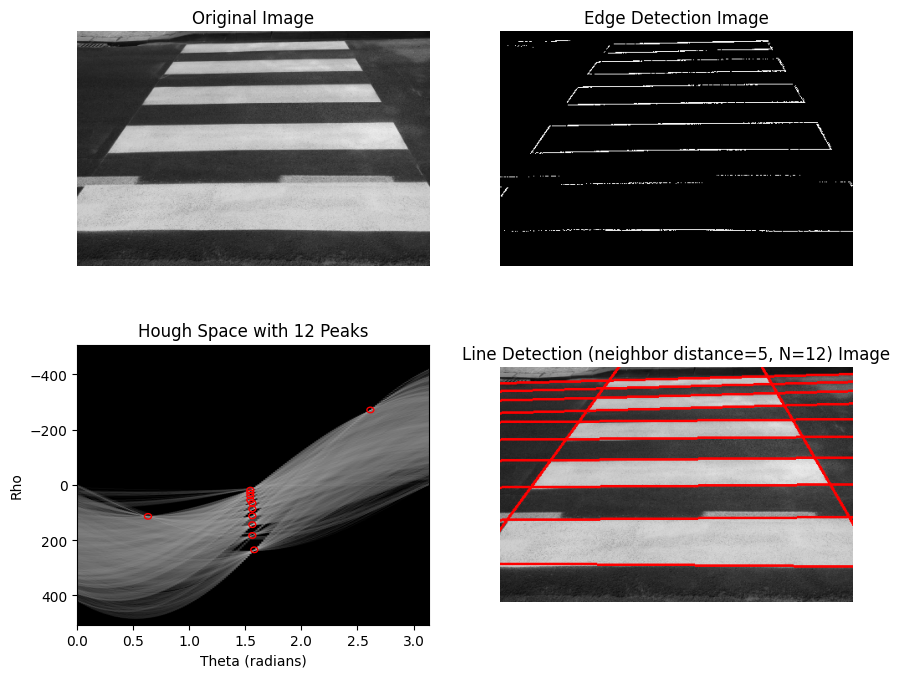

In [ ]:
# N largest maxima
MAX_N = 12
# Test with two neighborhood radius
peaks_1 = detect_peaks(accumulator, N=MAX_N, radius=1)
peaks_10 = detect_peaks(accumulator, N=MAX_N, radius=5)
# Draw lines
lines_image1 = draw_lines(crosswalk_img_arr, peaks_1, rhos, thetas)
lines_image10 = draw_lines(crosswalk_img_arr, peaks_10, rhos, thetas)
# Show images
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.imshow(crosswalk_img, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(2,2,2)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Edge Detection Image')
plt.subplot(2,2,3)
# plt.imshow(lines_image1, cmap='gray')
# plt.axis('off')
# plt.title('Line Detection (neighbor distance=1, N=12) Image')
draw_peaks(accumulator, peaks_10, thetas, rhos)
plt.subplot(2,2,4)
plt.imshow(lines_image10, cmap='gray')
plt.axis('off')
plt.title('Line Detection (neighbor distance=5, N=12) Image')
plt.show()

In [ ]:
# plt.imshow(lines_image10, cmap='gray')
# plt.axis('off')
# plt.title('Line Detection (neighbor distance=5, N=12) Image')
# draw_peaks(accumulator, peaks_10, thetas, rhos)

In [ ]:
# Get image and array
lines_img = Image.open('/content/drive/MyDrive/ComputerVision_Project3/mnn4-runway-Ohio.jpg')
lines_img_arr = np.array(lines_img)
# Get gradient magnitude
l_first_der_x,l_first_der_y = first_derivatives(lines_img_arr)
l_first_der_gradient = gradient_magnitude(l_first_der_x, l_first_der_y)
# Adjust values for display
l_dx_adjusted = imageAdjust(l_first_der_x)
l_dy_adjusted = imageAdjust(l_first_der_y)
l_magnitude_adjusted = imageAdjust(l_first_der_gradient)
# Threshold the magnitude image
l_thresholded_20 = threshold_image(l_magnitude_adjusted, 60)
l_thresholded_80 = threshold_image(l_magnitude_adjusted, 100)

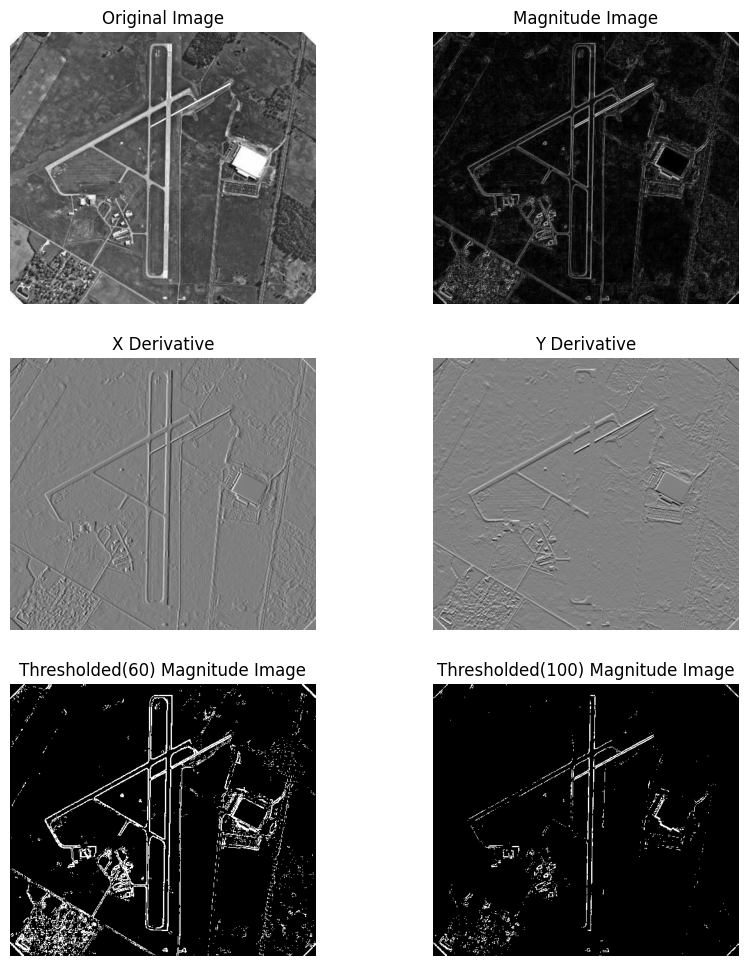

In [ ]:
# Show images
plt.figure(figsize=(10, 12))
plt.subplot(3, 2, 1)
plt.imshow(lines_img_arr, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(3, 2, 2)
plt.imshow(l_magnitude_adjusted, cmap='gray')
plt.title('Magnitude Image')
plt.axis('off')
plt.subplot(3, 2, 3)
plt.imshow(l_dx_adjusted, cmap='gray')
plt.title('X Derivative')
plt.axis('off')
plt.subplot(3, 2, 4)
plt.imshow(l_dy_adjusted, cmap='gray')
plt.title('Y Derivative')
plt.axis('off')
plt.subplot(3, 2, 5)
plt.imshow(l_thresholded_20, cmap='gray')
plt.title('Thresholded(60) Magnitude Image')
plt.axis('off')
plt.subplot(3, 2, 6)
plt.imshow(l_thresholded_80, cmap='gray')
plt.title('Thresholded(100) Magnitude Image')
plt.axis('off')
plt.show()

In [ ]:
# Airport runway image
l_image = l_thresholded_80
# Airport runway image Hough space
l_accumulator, l_thetas, l_rhos = hough_transform(l_image)

(0.01755079694742901, 245) 317
(1.0705986137931696, 234) 138
(1.0705986137931696, 217) 130
(3.141592653589793, -245) 104


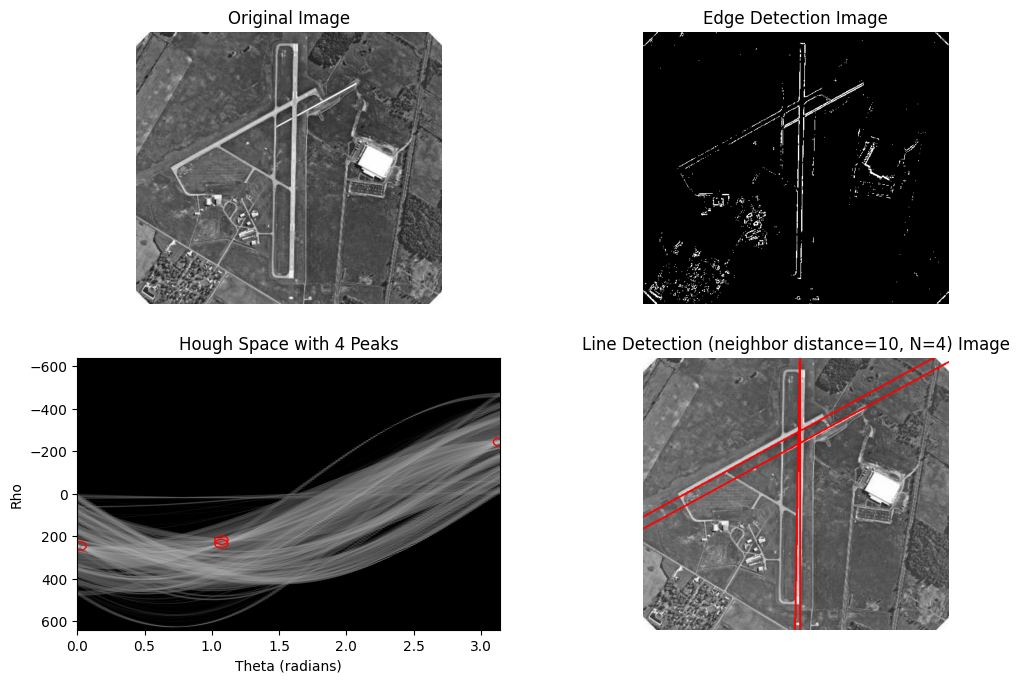

In [ ]:
# N largest maxima
MAX_N = 4
# Test with two neighborhood radius
l_peaks_1 = detect_peaks(l_accumulator, N=MAX_N, radius=1)
l_peaks_10 = detect_peaks(l_accumulator, N=MAX_N, radius=10)
# Draw lines
l_lines_image1 = draw_lines(lines_img_arr, l_peaks_1, l_rhos, l_thetas)
l_lines_image10 = draw_lines(lines_img_arr, l_peaks_10, l_rhos, l_thetas)
# Show images
plt.figure(figsize=(12, 12))
plt.subplot(3,2,1)
plt.imshow(lines_img, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(l_image, cmap='gray')
plt.axis('off')
plt.title('Edge Detection Image')
plt.subplot(3,2,3)
# plt.imshow(l_lines_image1, cmap='gray')
# plt.axis('off')
# plt.title('Line Detection (neighbor distance=1, N=4) Image')
draw_peaks(l_accumulator, l_peaks_10, l_thetas, l_rhos, ellipse_h=40)
plt.subplot(3,2,4)
plt.imshow(l_lines_image10, cmap='gray')
plt.axis('off')
plt.title('Line Detection (neighbor distance=10, N=4) Image')

plt.show()

In [ ]:
# plt.imshow(l_lines_image10, cmap='gray')
# plt.axis('off')
# plt.title('Line Detection (neighbor distance=10, N=4) Image')
# # Draw Hough space
# draw_peaks(l_accumulator, l_peaks_10, l_thetas, l_rhos, ellipse_h=40)

In [ ]:
# Get image and array
road_img = Image.open('/content/drive/MyDrive/ComputerVision_Project3/road-line-detection-0.jpeg')
resize_scale = .4
road_img = road_img.resize([int(road_img.size[0] * resize_scale),
                            int(road_img.size[1] * resize_scale)])
road_img_arr = np.array(road_img.convert('L')).astype(float)
# Get gradient magnitude
r_first_der_x,r_first_der_y = first_derivatives(road_img_arr)
r_first_der_gradient = gradient_magnitude(r_first_der_x, r_first_der_y)
# Adjust values for display
r_dx_adjusted = imageAdjust(r_first_der_x)
r_dy_adjusted = imageAdjust(r_first_der_y)
r_magnitude_adjusted = imageAdjust(r_first_der_gradient)

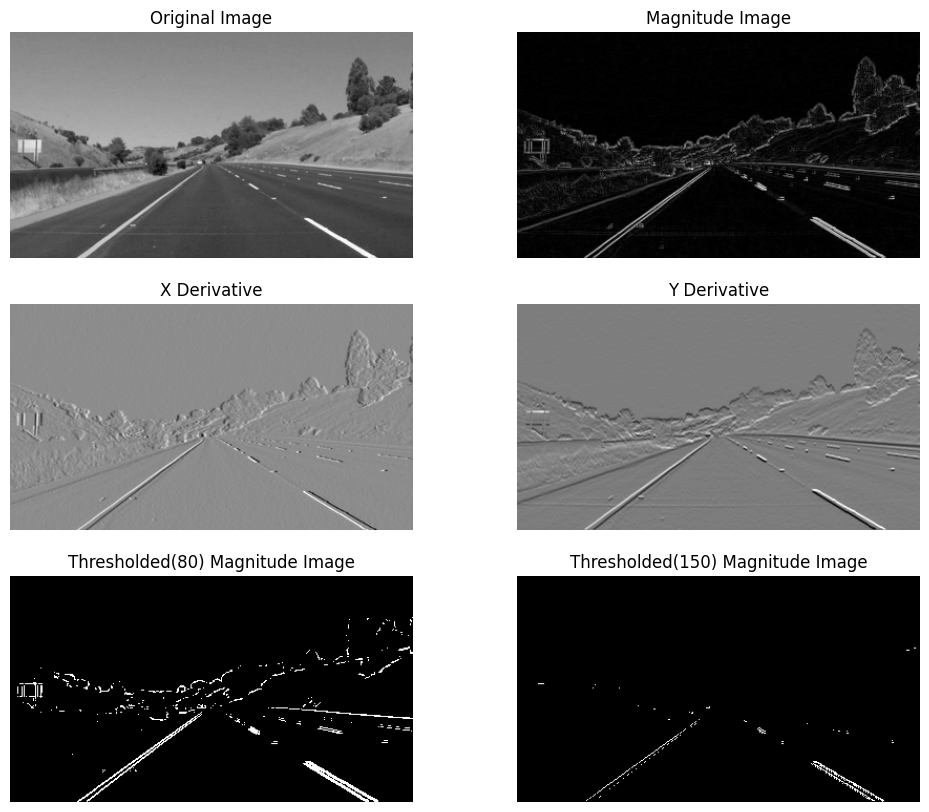

In [ ]:
# Threshold the magnitude image
r_thresholded_80 = threshold_image(r_magnitude_adjusted, 80)
r_thresholded_150 = threshold_image(r_magnitude_adjusted, 150)
# Show images
plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 1)
plt.imshow(road_img_arr, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(3, 2, 2)
plt.imshow(r_magnitude_adjusted, cmap='gray')
plt.title('Magnitude Image')
plt.axis('off')
plt.subplot(3, 2, 3)
plt.imshow(r_dx_adjusted, cmap='gray')
plt.title('X Derivative')
plt.axis('off')
plt.subplot(3, 2, 4)
plt.imshow(r_dy_adjusted, cmap='gray')
plt.title('Y Derivative')
plt.axis('off')
plt.subplot(3, 2, 5)
plt.imshow(r_thresholded_80, cmap='gray')
plt.title('Thresholded(80) Magnitude Image')
plt.axis('off')
plt.subplot(3, 2, 6)
plt.imshow(r_thresholded_150, cmap='gray')
plt.title('Thresholded(150) Magnitude Image')
plt.axis('off')
plt.show()

In [ ]:
r_image = r_thresholded_150

r_accumulator, r_thetas, r_rhos = hough_transform(r_image)

(2.0885448367440524, 13) 84
(0.9477430351611665, 212) 64


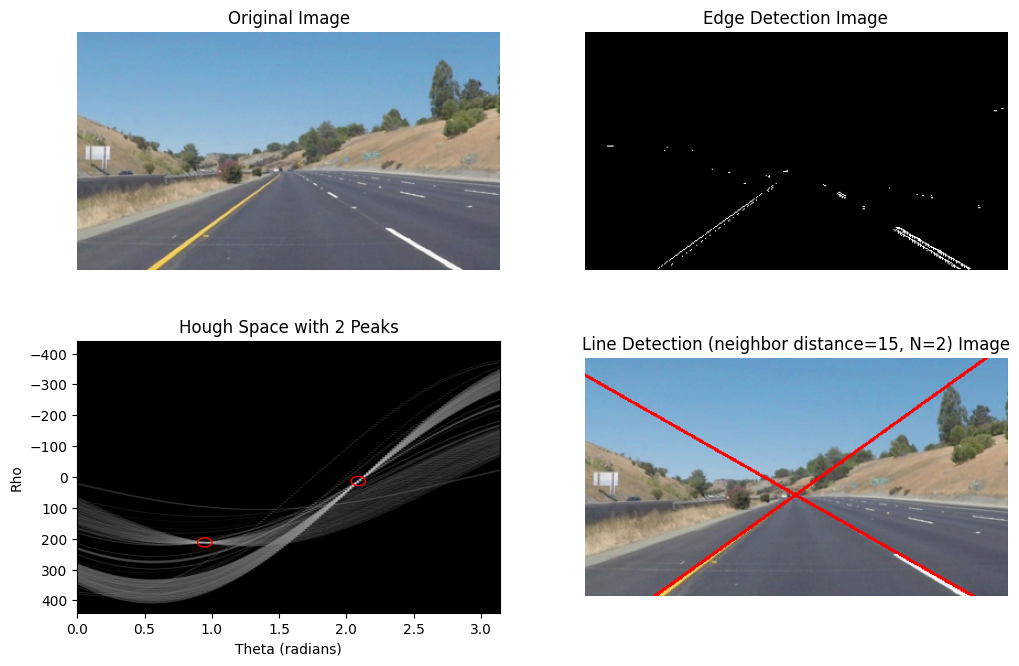

In [ ]:
MAX_N = 2

r_peaks_1 = detect_peaks(r_accumulator, N=MAX_N, radius=1)
r_peaks_10 = detect_peaks(r_accumulator, N=MAX_N, radius=15)

r_lines_image1 = draw_lines(np.array(road_img), r_peaks_1, r_rhos, r_thetas,
                            isGreyscale=False)
r_lines_image10 = draw_lines(np.array(road_img), r_peaks_10, r_rhos, r_thetas,
                             isGreyscale=False)


plt.figure(figsize=(12, 12))
plt.subplot(3,2,1)
plt.imshow(road_img, cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(3,2,2)
plt.imshow(r_image, cmap='gray')
plt.axis('off')
plt.title('Edge Detection Image')

plt.subplot(3,2,3)
# plt.imshow(r_lines_image1, cmap='gray')
# plt.axis('off')
# plt.title('Line Detection (neighbor distance=1, N=2) Image')
draw_peaks(r_accumulator, r_peaks_10, r_thetas, r_rhos, ellipse_h=30)

plt.subplot(3,2,4)
plt.imshow(r_lines_image10, cmap='gray')
plt.axis('off')
plt.title('Line Detection (neighbor distance=15, N=2) Image')

plt.show()

In [ ]:
# draw_peaks(r_accumulator, r_peaks_10, r_thetas, r_rhos, ellipse_h=30)

In [ ]:
hw_img = Image.open('/content/drive/MyDrive/ComputerVision_Project3/parking-lot-striping.jpeg')
resize_scale = .6
hw_img = hw_img.resize([int(hw_img.size[0] * resize_scale), int(hw_img.size[1] * resize_scale)])
hw_img_arr = np.array(hw_img.convert('L')).astype(float)

h_first_der_x,h_first_der_y = first_derivatives(hw_img_arr)
h_first_der_gradient = gradient_magnitude(h_first_der_x, h_first_der_y)
h_dx_adjusted = imageAdjust(h_first_der_x)
h_dy_adjusted = imageAdjust(h_first_der_y)
h_magnitude_adjusted = imageAdjust(h_first_der_gradient)

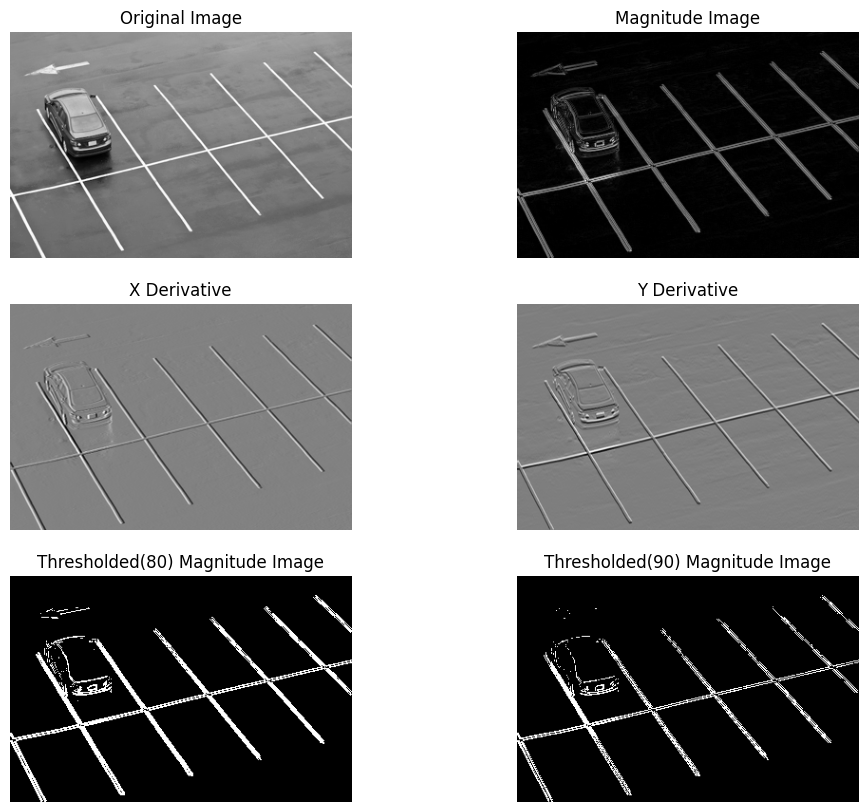

In [ ]:
h_thresholded_80 = threshold_image(h_magnitude_adjusted, 70)
h_thresholded_90 = threshold_image(h_magnitude_adjusted, 90)
plt.figure(figsize=(12, 10))
plt.subplot(3, 2, 1)
plt.imshow(hw_img_arr, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(3, 2, 2)
plt.imshow(h_magnitude_adjusted, cmap='gray')
plt.title('Magnitude Image')
plt.axis('off')
plt.subplot(3, 2, 3)
plt.imshow(h_dx_adjusted, cmap='gray')
plt.title('X Derivative')
plt.axis('off')
plt.subplot(3, 2, 4)
plt.imshow(h_dy_adjusted, cmap='gray')
plt.title('Y Derivative')
plt.axis('off')
plt.subplot(3, 2, 5)
plt.imshow(h_thresholded_80, cmap='gray')
plt.title('Thresholded(80) Magnitude Image')
plt.axis('off')
plt.subplot(3, 2, 6)
plt.imshow(h_thresholded_90, cmap='gray')
plt.title('Thresholded(90) Magnitude Image')
plt.axis('off')
plt.show()

In [ ]:
h_image = median_filter(h_thresholded_90, 5)
h_accumulator, h_thetas, h_rhos = hough_transform(h_thresholded_90)
h_accumulator2, h_thetas2, h_rhos2 = hough_transform(h_image)

(2.5975179482194934, 18) 167
(2.5273147604297774, -34) 161
(1.3338605680046047, 170) 159
(2.4571115726400614, -81) 138
(2.4044591817977743, -125) 113
(2.685271932956639, 73) 77
(2.3518067909554876, -164) 64


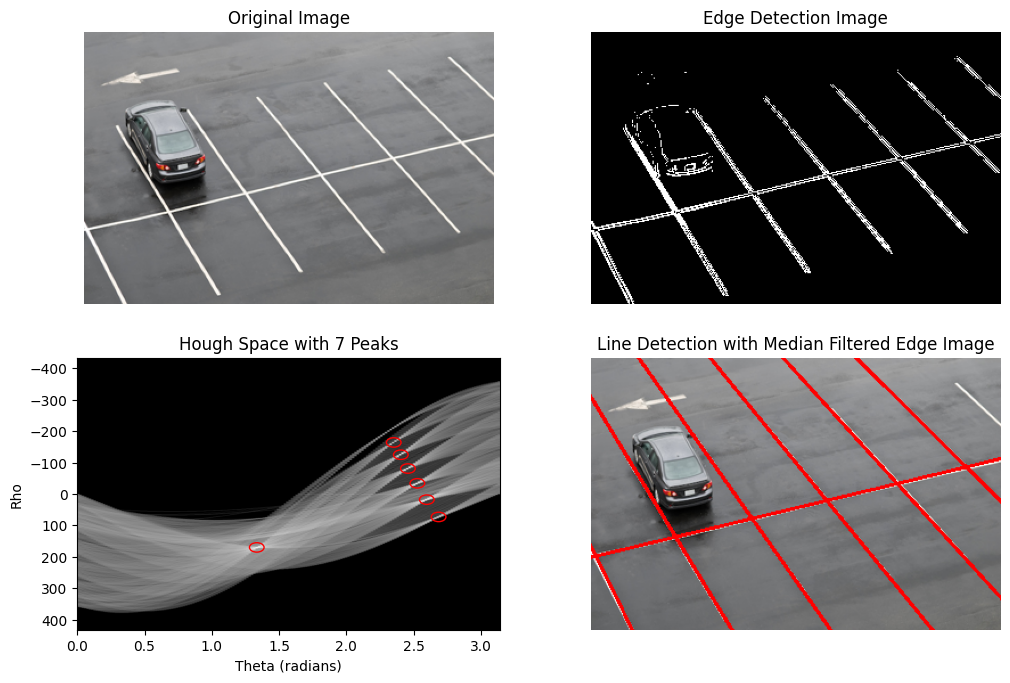

In [ ]:
MAX_N = 7

h_peaks_1 = detect_peaks(h_accumulator, N=MAX_N, radius=10)
h_peaks_10 = detect_peaks(h_accumulator2, N=MAX_N, radius=10)

h_lines_image1 = draw_lines(np.array(hw_img), h_peaks_1, h_rhos, h_thetas,
                            isGreyscale=False)
h_lines_image2 = draw_lines(np.array(hw_img), h_peaks_10, h_rhos2, h_thetas2,
                            isGreyscale=False)


plt.figure(figsize=(12, 12))
plt.subplot(3,2,1)
plt.imshow(hw_img, cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(3,2,2)
plt.imshow(h_thresholded_90, cmap='gray')
plt.axis('off')
plt.title('Edge Detection Image')

# plt.subplot(3,2,2)
# plt.imshow(h_image, cmap='gray')
# plt.axis('off')
# plt.title('Median Filtered Edge Detection Image')

plt.subplot(3,2,3)
# plt.imshow(h_lines_image1, cmap='gray')
# plt.axis('off')
# plt.title('Line Detection with Normal Edge Detection Image')
draw_peaks(h_accumulator, h_peaks_10, h_thetas, h_rhos, ellipse_h=30)

plt.subplot(3,2,4)
plt.imshow(h_lines_image2, cmap='gray')
plt.axis('off')
plt.title('Line Detection with Median Filtered Edge Image')

plt.show()

In [ ]:
# draw_peaks(h_accumulator, h_peaks_10, h_thetas, h_rhos, ellipse_h=30)